<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/10-attention-mechanisms/01_attention_mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Attention mechanisms

Deep learning models can also learn to pay attention to some input, or features, and
ignore other features. They do this with attention mechanisms, which are another type of
prior belief we can impose on our network. 

Attention mechanisms help us deal with
situations where part of our input may be irrelevant, or when we need to focus on one
feature of many features being fed into the model.

We would like to endow our networks with the ability to ignore superfluous and
distracting inputs to focus on the most important portions, and that’s the goal of
an attention mechanism. 

If you believe some of your input features are more or less
important than other features, you should consider using an attention-based approach
in your model. 

If you want state-of-the-art results on speech recognition, object detection,
a chat bot, or machine translation, for instance, you will probably be using an attention
mechanism.

In this notebook, we see how attention works on some toy problems out of the MNIST dataset that is too hard for a normal network but is easily and better
solved with a simple kind of attention that learns how to score the importance of each
item in the input. 

Then we improve the simple attention into a full-fledged approach
that takes into account some context to better infer the importance of items in the input.

##Setup

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_network, Flatten, weight_reset, View, set_seed

In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [4]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

Now that we can load the dataset.

In [ ]:
# let’s quickly load MNIST dataset
mnist_train = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

Attention mechanisms are most useful when we have multiple items as inputs into our model.

Since MNIST is a single digit, we will augment each item in MNIST to become a
bag of digits. We use fully connected layers for this (i.e., flattened MNIST, ignoring the
image nature), so instead of having a batch of digits `(B,D)`, we have `T` digits `(B, T, D)`.

So why did I call this a bag instead of a sequence? 

Because we don’t care in what order
the digits are presented in the tensor. We just need a tensor large enough to hold everything in the bag.

Given a bag of digits $x_1, x_2, ... , x_T$ , we have a label y that is equal to the largest digit in the bag. If our bag contains 0, 2, 9, the label for the bag is “9.”

Let's implements a LargestDigit class to wrap an input dataset and create new items by
randomly filling a bag of toSample items and selecting the maximum label value.

In [7]:
class LargestDigit(Dataset):
  """
  Creates a modified version of a dataset where some number of samples are taken, 
  and the true label is the largest label sampled. When used with MNIST the labels 
  correspond to their values (e.g., digit "6" has label 6)
  """
  def __init__(self, dataset, toSample=3):
    """
    dataset: the dataset to sample from
    toSample: the number of items from the dataset to sample
    """
    self.dataset = dataset
    self.toSample = toSample 

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    # Randomly select n=self.toSample items from the dataset
    selected = np.random.randint(0, len(self.dataset), size=self.toSample)
    
    # Stack the n items of shape (B, *) shape into (B, n, *)
    x_new = torch.stack([self.dataset[i][0] for i in selected])
    # Label is the maximum label
    y_new = max([self.dataset[i][1] for i in selected])
    
    # Return (data, label) pair!
    return x_new, y_new

In [8]:
B = 128
epochs= 10

largest_train = LargestDigit(mnist_train)
largest_test = LargestDigit(mnist_test)

train_loader = DataLoader(largest_train, batch_size=B, shuffle=True)
test_loader = DataLoader(largest_train, batch_size=B)

True Label is = 8


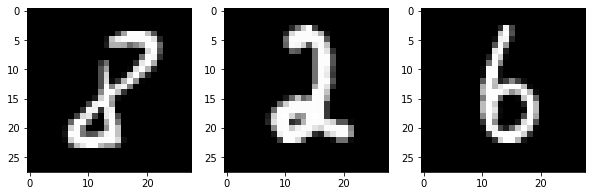

In [9]:
# Want a consistent dataset split
set_seed(34)

x, y = largest_train[0]

f, axarr = plt.subplots(1, 3, figsize=(10, 10))
for i in range(3):
  axarr[i].imshow(x[i, 0, :].numpy(), cmap="gray", vmin=0, vmax=1)
print(f"True Label is = {y}")

##Baseline Model

Let's train a simple fully connected network and treat
this like any other classification problem we might attempt. 

This will be our baseline
and show how hard the new version of MNIST is:.

In [10]:
neurons = 256     
classes = 10 

In [11]:
simple_net = nn.Sequential(
  nn.Flatten(),
  nn.Linear(784 * 3, neurons), # 784*3 because there are 784 pixels in an image and 3 images in the bag
  nn.LeakyReLU(),
  nn.BatchNorm1d(neurons),

  nn.Linear(neurons, neurons),
  nn.LeakyReLU(),
  nn.BatchNorm1d(neurons),

  nn.Linear(neurons, neurons),
  nn.LeakyReLU(),
  nn.BatchNorm1d(neurons),

  nn.Linear(neurons, classes)
)

Let's train this model.

In [ ]:
simple_results = train_network(simple_net, 
                               nn.CrossEntropyLoss(), 
                               train_loader, 
                               val_loader=test_loader,
                               epochs=epochs,
                               score_funcs={"Accuracy": accuracy_score},
                               device=device)

Now let’s plot the results.

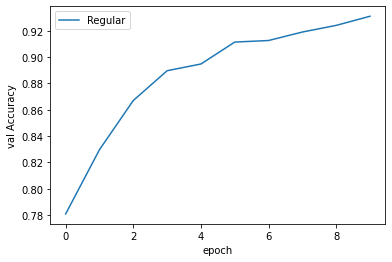

In [13]:
sns.lineplot(x="epoch", y="val Accuracy", data=simple_results, label="Regular")

##Attention mechanics

We need a new version of the nn.Flatten
function that leaves the first two axes of our tensor alone.

In [14]:
class FlattenLayer(nn.Module):
  """
  Takes a vector of shape (A, B, C, D, E, ...)
  and flattens everything but the first two dimensions, 
  giving a result of shape (A, B, C*D*E*...)
  """
  def forward(self, input):
    return input.view(input.size(0), input.size(1), -1)

Let's create a Combiner class that will combine the attention weights $\alpha$ with the extracted feature representations $h_1,h_2,..., h_T$ and computes the weighted average $\bar x = \Sigma_{i=1}^T \alpha_i.h_i$

In [15]:
class Combiner(nn.Module):
  """
  This class is used to combine a feature exraction network F and a importance prediction network W,
  and combine their outputs by adding and summing them together. 
  """
  def __init__(self, feature_extraction, weight_selection):
    """
    featureExtraction: a network that takes an input of shape (B, T, D) and outputs a new representation of shape (B, T, D'). 
    weightSelection: a network that takes in an input of shape (B, T, D') and outputs a 
      tensor of shape (B, T, 1) or (B, T). It should be normalized, so that the T values at the end sum to one (torch.sum(_, dim=1) = 1.0)
    """
    super(Combiner, self).__init__()
    self.feature_extraction = feature_extraction
    self.weight_selection = weight_selection

  def forward(self, input):
    """
    input: a tensor of shape (B, T, D)
    return: a new tensor of shape (B, D')
    """
    features = self.feature_extraction(input)  # (B, T, D) h_i = F(x_i)
    weights = self.weight_selection(features)  # (B, T) or (B, T, 1) for alpha
    if len(weights.shape) == 2:                # (B, T) shape
      weights.unsqueese(2)                     # Now (B, T, 1) shape
    
    result = features * weights                # (B, T, D) computes alpha_i . h_i
    return torch.sum(result, dim=1)            # Sums over the T dimension, giving the (B, D) final shape

Now we are ready to define our attention-based model for this problem.